In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
from custom_layers import *
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import models as my_models

In [4]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.utils import class_weight

In [5]:
from psyki.logic import Theory
from psyki.logic.prolog import TuProlog
from psyki.ski import Injector

In [6]:
np.set_printoptions(precision=3, suppress=True)
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
X = pd.read_csv('pima_indians_imputed.csv')

dataset = X.copy()
# X = pd.read_csv('diabetes.csv')
# y = X["Outcome"]
# X.drop(columns=["Outcome"],inplace=True)

y = X["Outcome"]
X.drop(columns=["Unnamed: 0","Outcome"],inplace=True)

In [8]:
ones = sum(y==1)
zeros = sum(y==0)

print(ones)
print(zeros)

abs(zeros - ones) / y.shape[0]


268
500


0.3020833333333333

In [9]:
scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X)


maxes = scaler.data_max_

# X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.33, random_state=42)

tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X)

In [10]:
null_counts_per_row = X.isnull().sum(axis=0)

null_counts_per_row

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

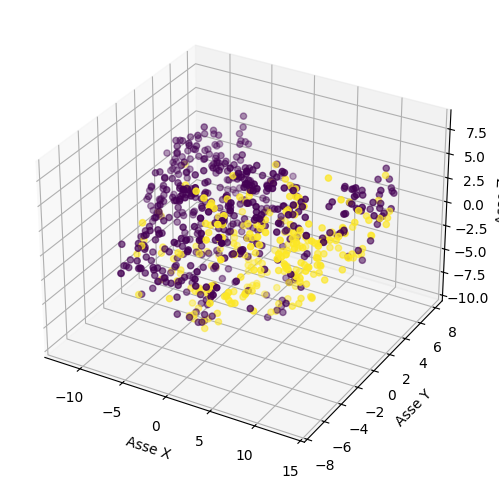

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y, marker='o')

# Etichette degli assi
ax.set_xlabel('Asse X')
ax.set_ylabel('Asse Y')
ax.set_zlabel('Asse Z')

plt.grid(True)
plt.show()

In [12]:
cw = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
class_0_weight = cw[0]
class_1_weight = cw[1]

In [13]:
layers_number = 2
units = 15
learning_rate = 0.00001
input_shape = (X.shape[1:])
EPOCHS = 100

n_splits = 4

training_uneducated = False

In [14]:
knowledge = TuProlog.from_file("./knowledge/diabetes.pl")
theory = Theory(knowledge, dataset)
for rule in theory.formulae:
    print(f"{rule.rhs} -> {rule.lhs.args.last}")

Glucose > 126.0, BMI > 30.0 -> 1.0
Glucose =< 100.0, BMI =< 25.0 -> 0.0


In [19]:
kf = KFold(
    n_splits=n_splits,
    # random_state=42
)

all_score = []
accuracy_on_rule_1 = 0
accuracy_on_rule_2 = 0

rule_1_count = 0
rule_2_count = 0


for train_index, val_index in kf.split(X):
    early_stopping = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
    )
    # Suddividi il dataset in fold di training e validation
    train = dataset.iloc[train_index,:]
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    cw = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_val), y=y_val)
    class_0_weight = cw[0]
    class_1_weight = cw[1]

    uneducated = my_models.getBaseModel(
        input_shape,
        units,
        layers_number,
    )

    if(training_uneducated):
        model = uneducated
    else:        
        theory = Theory(knowledge, train)

        injector = Injector.kbann(uneducated)
        model = injector.inject(theory)
        y_train = np.column_stack([y_train,y_train])
        y_val = np.column_stack([y_val,y_val])
        # plot_model(model, to_file='educated_structure1.png', show_shapes=True, show_layer_names=True)
        # 1/0

        # last = layers.Dense(units=1, activation="sigmoid")(model.output)
        # model = keras.Model(inputs=model.input, outputs=last)
        
    model.compile(
        optimizer = "adam",
        loss="binary_crossentropy",
        metrics=['accuracy'],            
    )

    model.fit(
        X_train,
        y_train,
        # class_weight={0:cw[0],1:cw[1]},
        batch_size=32,
        epochs=EPOCHS,
        callbacks=[early_stopping]
    )

    prediction = model.predict(X_val)

    # first_rule_true = y_val[(X_val["BMI"] <= 25 / maxes[5]) & (X_val["Glucose"] <= 100/ maxes[1]) & (y_val==0)]
    # first_rule_pred = prediction[(X_val["BMI"] <= 25 / maxes[5]) & (X_val["Glucose"] <= 100/ maxes[1]) & (y_val==0)]>0.5
    # second_rule_true = y_val[(X_val["BMI"] >= 30 / maxes[5]) & (X_val["Glucose"] >= 126/ maxes[1]) & (y_val==1)]
    # second_rule_pred = prediction[(X_val["BMI"] >= 30 / maxes[5]) & (X_val["Glucose"] >= 126/ maxes[1]) & (y_val==1)]>0.5
    

    all_score.append([
        accuracy_score(y_val, prediction>0.5), # accuracy
        # balanced_accuracy_score(y_val, prediction>0.5), # balanced accuracy
        # recall_score(y_val, prediction>0.5), # recall
        # recall_score(y_val == 0, prediction<0.5), # recall on 0
    ])

    # if(len(first_rule_true) > 0 and len(first_rule_pred)>0):
    #     accuracy_on_rule_1 += accuracy_score(first_rule_true, first_rule_pred)
    #     rule_1_count += 1

    # if(len(second_rule_true) > 0 and len(second_rule_pred)>0):
    #     accuracy_on_rule_2 += accuracy_score(second_rule_true, second_rule_pred)
    #     rule_2_count += 1

all_score = np.sum(np.array(all_score), axis=0)
all_score = all_score / n_splits

# accuracy_on_rule_1 /= rule_1_count
# accuracy_on_rule_2 /= rule_2_count



Epoch 1/100
18/18 [==============================] - 1s 7ms/step - loss: 1.7557 - accuracy: 0.0000e+00
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 1.7557 - accuracy: 0.0000e+00
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 1.7557 - accuracy: 0.0000e+00
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 1.7557 - accuracy: 0.0000e+00
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 1.7557 - accuracy: 0.0000e+00
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 1.7557 - accuracy: 0.0000e+00
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 1.7557 - accuracy: 0.0000e+00
Epoch 8/100
18/18 [==============================] - 0s 5ms/step - loss: 1.7557 - accuracy: 0.0000e+00
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 1.7557 - accuracy: 0.0000e+00
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - loss:

In [20]:
if(training_uneducated):
    print("Uneducated performance")
else:
    print("Educated performance")

print("Test accuracy")
print(all_score[0],end="\n\n")

print("Test balanced accuracy")
print(all_score[1],end="\n\n")

print("Test recall")
print(all_score[2],end="\n\n")

print("Test recall on 0")
print(all_score[3],end="\n\n")

print("Knowledge BMI<=25 & Glucose<=100 accuracy")
print(accuracy_on_rule_1,end="\n\n")

print("Knowledge BMI>=30 & Glucose>=126 accuracy")
print(accuracy_on_rule_2)


Educated performance
Test accuracy
0.0

Test balanced accuracy


IndexError: index 1 is out of bounds for axis 0 with size 1